<a href="https://colab.research.google.com/github/tannisthamaiti/AIWeekend-Project/blob/main/Transformer/Transformer_chatbot_complex_movie_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [90]:
!pip install datasets torch transformers
!wget http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip
!unzip -qq cornell_movie_dialogs_corpus.zip
!rm cornell_movie_dialogs_corpus.zip
!mkdir datasets
!mv cornell\ movie-dialogs\ corpus/movie_conversations.txt ./datasets
!mv cornell\ movie-dialogs\ corpus/movie_lines.txt ./datasets

URL transformed to HTTPS due to an HSTS policy
--2025-05-15 10:58:10--  https://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.53
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9916637 (9.5M) [application/zip]
Saving to: ‘cornell_movie_dialogs_corpus.zip’

cornell_movie_dialo 100%[===================>]   9.46M  4.19MB/s    in 2.3s    

2025-05-15 10:58:13 (4.19 MB/s) - ‘cornell_movie_dialogs_corpus.zip’ saved [9916637/9916637]

replace cornell movie-dialogs corpus/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/cornell movie-dialogs corpus/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace cornell movie-dialogs corpus/chameleons.pdf? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/cornell movie-dialogs corpus/._chameleons.pdf? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
rep

## Data Processing

This tutorial trains a Transformer model to be a chatbot. This is an advanced example that assumes knowledge of text generation, attention and transformer.

We will use the conversations in movies and TV shows provided by Cornell Movie-Dialogs Corpus, which contains more than 220 thousands conversational exchanges between more than 10k pairs of movie characters, as our dataset.

movie_conversations.txt contains list of the conversation IDs and movie_lines.text contains the text of assoicated with each conversation ID. For further information regarding the dataset, please check the README file in the zip file.

In [114]:
from collections import Counter
import json
import math


In [115]:
import torch ## torch let's us create tensors and also provides helper functions
import torch.nn as nn ## torch.nn gives us nn.module() and nn.Linear()
import torch.nn.functional as F # This gives us the softmax()
from torch.utils.data import TensorDataset, DataLoader, Dataset ## We'll store our data in DataLoaders
from torch.optim import Adam
import torch.optim as optim

In [116]:
def remove_punc(string):
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    no_punct = ""
    for char in string:
        if char not in punctuations:
            no_punct = no_punct + char  # space is also a character
    return no_punct.lower()

In [117]:
# data processing
max_len = 25

corpus_movie_conv = './datasets/movie_conversations.txt'
corpus_movie_lines = './datasets/movie_lines.txt'
with open(corpus_movie_conv, 'r', encoding='iso-8859-1') as c:
    conv = c.readlines()
with open(corpus_movie_lines, 'r', encoding='iso-8859-1') as l:
    lines = l.readlines()

# extract text
lines_dic = {}
for line in lines:
    objects = line.split(" +++$+++ ")
    lines_dic[objects[0]] = objects[-1]

In [118]:
# generate question answer pairs
pairs = []
for con in conv:
    ids = eval(con.split(" +++$+++ ")[-1])
    for i in range(len(ids)):
        qa_pairs = []

        if i == len(ids) - 1:
            break

        first = remove_punc(lines_dic[ids[i]].strip())
        second = remove_punc(lines_dic[ids[i+1]].strip())
        qa_pairs.append(first.split()[:max_len])
        qa_pairs.append(second.split()[:max_len])
        qa_pairs.append(second.split()[:max_len])
        pairs.append(qa_pairs)

# sample
print(pairs[20])

[['i', 'really', 'really', 'really', 'wanna', 'go', 'but', 'i', 'cant', 'not', 'unless', 'my', 'sister', 'goes'], ['im', 'workin', 'on', 'it', 'but', 'she', 'doesnt', 'seem', 'to', 'be', 'goin', 'for', 'him'], ['im', 'workin', 'on', 'it', 'but', 'she', 'doesnt', 'seem', 'to', 'be', 'goin', 'for', 'him']]


## Word Embedding

In [119]:
# word map
min_word_freq = 5

word_freq = Counter()
for pair in pairs:
    word_freq.update(pair[0])
    word_freq.update(pair[1])

words = [w for w in word_freq.keys() if word_freq[w] > min_word_freq]
word_map = {k: v + 1 for v, k in enumerate(words)}
word_map['<unk>'] = len(word_map) + 1
word_map['<start>'] = len(word_map) + 1
word_map['<end>'] = len(word_map) + 1
word_map['<pad>'] = 0

print("Total words are: {}".format(len(word_map)))

Total words are: 18243


In [120]:
from random import shuffle
# encode sentences based on word map
def encode_question(words, word_map):
    enc_c = [word_map.get(word, word_map['<unk>']) for word in words] + [word_map['<pad>']] * (max_len - len(words))
    return enc_c

def encode_reply_input(words, word_map):
    enc_c = [word_map['<start>']] + [word_map.get(word, word_map['<unk>']) for word in words]
    enc_c += [word_map['<pad>']] * (max_len - len(enc_c))
    return enc_c

def encode_reply(words, word_map):
    enc_c = [word_map.get(word, word_map['<unk>']) for word in words] + [word_map['<end>']]
    enc_c += [word_map['<pad>']] * (max_len - len(enc_c))
    return enc_c


pairs_encoded = []
for pair in pairs:
    qus = encode_question(pair[0], word_map)
    ans_input = encode_reply_input(pair[1], word_map)
    ans = encode_reply(pair[2], word_map)
    if len(qus) == 25 and len(ans_input) == 25 and len(ans) == 25:
      pairs_encoded.append([qus, ans_input,ans])
print(len(pairs_encoded))
# Shuffle the dataset first (important!)
shuffle(pairs_encoded)

# Define split sizes
total = len(pairs_encoded)
train_size = int(0.7 * total)
val_size = int(0.15 * total)
test_size = total - train_size - val_size

# Split the dataset
train_data = pairs_encoded[:train_size]
val_data = pairs_encoded[train_size:train_size + val_size]
test_data = pairs_encoded[train_size + val_size:]

202213


In [121]:
# dataset and dataloader
class Dataset(Dataset):

    def __init__(self, pairs):

        self.pairs = pairs
        self.dataset_size = len(self.pairs)

    def __getitem__(self, i):
        question = torch.LongTensor(self.pairs[i][0])
        reply_input = torch.LongTensor(self.pairs[i][1])
        reply = torch.LongTensor(self.pairs[i][2])
        return question, reply_input, reply

    def __len__(self):
        return self.dataset_size


#train_loader = DataLoader(Dataset(pairs_encoded), batch_size=32, shuffle=True, pin_memory=True)
train_loader = DataLoader(Dataset(train_data), batch_size=32, shuffle=True, pin_memory=True)
val_loader = DataLoader(Dataset(train_data), batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(Dataset(train_data), batch_size=1, shuffle=False, pin_memory=True)
question, reply_input, reply = next(iter(train_loader))
print("Question: ", question.size())
print("Answer: ", reply_input.size())
print("Answer: ", reply.size())

Question:  torch.Size([32, 25])
Answer:  torch.Size([32, 25])
Answer:  torch.Size([32, 25])


In [122]:
class PositionEncoding(nn.Module):

    def __init__(self, d_model=2, max_len=25):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(start=0, end=max_len, step=1).float().unsqueeze(1)
        embedding_index = torch.arange(start=0, end=d_model, step=2).float()
        div_term = 1/torch.tensor(10000.0)**(embedding_index / d_model)
        pe[:, 0::2] = torch.sin(position * div_term) ## every other column, starting with the 1st, has sin() values
        pe[:, 1::2] = torch.cos(position * div_term) ## every other column, starting with the 2nd, has cos() values

        ## Now we "register 'pe'.
        self.register_buffer('pe', pe)
    def forward(self, word_embeddings):

        return word_embeddings + self.pe[:word_embeddings.size(0), :]


In [123]:
class Attention(nn.Module):
    def __init__(self, d_model=2,row_dim=0,col_dim=1):
      super().__init__()
      self.W_q = nn.Linear(in_features=d_model, out_features=d_model, bias=False)
      self.W_k = nn.Linear(in_features=d_model, out_features=d_model, bias=False)
      self.W_v = nn.Linear(in_features=d_model, out_features=d_model, bias=False)

      self.row_dim = row_dim
      self.col_dim = col_dim


    ## The only change from SelfAttention and attention is that
    ## now we expect 3 sets of encodings to be passed in...
    def forward(self, encodings_for_q, encodings_for_k, encodings_for_v, mask=None):
        ## ...and we pass those sets of encodings to the various weight matrices.
        q = self.W_q(encodings_for_q)
        k = self.W_k(encodings_for_k)
        v = self.W_v(encodings_for_v)
        # Transpose keys: [batch_size, d_model, seq_len_k]
        if q.dim() == 3:  # [batch_size, seq_len, d_model]
          k_t = k.transpose(1, 2)         # [batch_size, d_model, seq_len]
          sims = torch.bmm(q, k_t)        # [batch_size, seq_len_q, seq_len_k]
        else:  # assume [seq_len, d_model] (no batch)
          k_t = k.transpose(0, 1)         # [d_model, seq_len]
          sims = torch.matmul(q, k_t)     # [seq_len_q, seq_len_k]

        scaled_sims = sims / torch.tensor(k.size(-1)**0.5)


        if mask is not None:
            #print("mask.shape, scaled_sims.shape",mask.shape, scaled_sims.shape )
            scaled_sims = scaled_sims.masked_fill(mask=mask, value=-1e9)

        attention_percents = F.softmax(scaled_sims, dim=self.col_dim)

        attention_scores = torch.matmul(attention_percents, v)

        return attention_scores

In [124]:
class Encoder(nn.Module):

    def __init__(self, num_tokens=4, d_model=2, max_len=6):

        super().__init__()


        self.we = nn.Embedding(num_embeddings=num_tokens,
                               embedding_dim=d_model)

        self.pe = PositionEncoding(d_model=d_model,
                                   max_len=max_len)

        self.self_attention = Attention(d_model=d_model)
        self.layernorm = nn.LayerNorm(d_model)

        self.fc_layer = nn.Linear(in_features=d_model, out_features=num_tokens)




    def forward(self, token_ids):

        token_ids = token_ids.to(self.we.weight.device)

        word_embeddings = self.we(token_ids)

        position_encoded = self.pe(word_embeddings)

        self_attention_values = self.self_attention(position_encoded,
                                                    position_encoded,
                                                    position_encoded,
                                                    mask=None)


        residual_connection_values = self.layernorm(position_encoded + self_attention_values)

        fc_layer_output = self.fc_layer(residual_connection_values)

        return residual_connection_values, residual_connection_values


In [125]:
class Decoder(nn.Module):
    def __init__(self, num_tokens=4, d_model=2, max_len=6):
        super().__init__()

        self.we = nn.Embedding(num_embeddings=num_tokens, embedding_dim=d_model)
        self.pe = PositionEncoding(d_model=d_model, max_len=max_len)

        self.self_attention = Attention(d_model=d_model)
        self.cross_attention = Attention(d_model=d_model)
        self.layernorm1 = nn.LayerNorm(d_model)
        self.layernorm2 = nn.LayerNorm(d_model)

        self.fc_layer = nn.Linear(in_features=d_model, out_features=num_tokens)

    def forward(self, token_ids, encoder_k, encoder_v):
        device = self.we.weight.device  # ensure all tensors follow this device

        token_ids = token_ids.to(device)
        word_embeddings = self.we(token_ids)
        position_encoded = self.pe(word_embeddings)

        # Create causal mask
        seq_len = token_ids.size(1) if token_ids.dim() == 2 else token_ids.size(0)
        batch_size = token_ids.size(0) if token_ids.dim() == 2 else 1
        mask = torch.tril(torch.ones((seq_len, seq_len), device=device)).unsqueeze(0)
        mask = mask.expand(batch_size, -1, -1)  # [batch_size, seq_len, seq_len]
        mask = mask == 0  # convert to True/False for masked_fill

        # Self-attention with mask
        mask_self_attention_values = self.self_attention(
            position_encoded, position_encoded, position_encoded, mask=mask
        )

        # Residual connection + layer norm
        residual_connection_values = self.layernorm1(position_encoded + mask_self_attention_values)

        # Cross-attention (no mask)
        x_cross_att = self.cross_attention(residual_connection_values, encoder_k, encoder_v, mask=None)
        x = self.layernorm2(residual_connection_values + x_cross_att)

        fc_layer_output = self.fc_layer(x)
        return fc_layer_output


In [126]:
## First, create a model from DecoderOnlyTransformer()
model = Encoder(num_tokens=len(word_map), d_model=2, max_len=25)


## Now create the input for the transformer...
question_test = pairs[20][0]
print(question_test)
mapped_values = [word_map[word] for word in question_test]
encoder_input = torch.tensor(mapped_values)
print("encoder_input", encoder_input.shape)

## Now get get predictions from the model
encoder_k, encoder_v = model(encoder_input)
answer_test = pairs[20][1]
print(answer_test)
mapped_values = [word_map['<start>']]+[word_map[word] for word in answer_test]
decoder_input = torch.tensor(mapped_values)
print("decoder_input", decoder_input.shape)
decoder = Decoder(num_tokens=len(word_map), d_model=2, max_len=25)
output = decoder(decoder_input, encoder_k, encoder_v)

print(output)



['i', 'really', 'really', 'really', 'wanna', 'go', 'but', 'i', 'cant', 'not', 'unless', 'my', 'sister', 'goes']
encoder_input torch.Size([14])
['im', 'workin', 'on', 'it', 'but', 'she', 'doesnt', 'seem', 'to', 'be', 'goin', 'for', 'him']
decoder_input torch.Size([14])
tensor([[-0.2263,  0.4737, -0.6455,  ..., -0.3704,  0.0500, -0.7724],
        [-0.0457, -0.6998,  1.2509,  ...,  1.3396, -0.6517, -0.4627],
        [-0.2263,  0.4737, -0.6455,  ..., -0.3704,  0.0500, -0.7724],
        ...,
        [-0.2263,  0.4737, -0.6455,  ..., -0.3704,  0.0500, -0.7724],
        [-0.2263,  0.4737, -0.6455,  ..., -0.3704,  0.0500, -0.7724],
        [-0.0457, -0.6998,  1.2509,  ...,  1.3396, -0.6517, -0.4627]],
       grad_fn=<AddmmBackward0>)


In [127]:

# Hyperparameters
num_tokens = len(word_map)
d_model = 2
max_len = 25
batch_size = 32
num_epochs = 2
learning_rate = 0.001

In [128]:
# Create the transformer model
class Transformer(nn.Module):
    def __init__(self, num_tokens, d_model, max_len):
        super().__init__()

        self.encoder = Encoder(num_tokens=num_tokens, d_model=d_model, max_len=max_len)
        self.decoder = Decoder(num_tokens=num_tokens, d_model=d_model, max_len=max_len)

        # Output projection layer
        self.output_linear = nn.Linear(num_tokens, num_tokens)

    def forward(self, src_tokens, tgt_tokens):
        # Pass source tokens through encoder
        encoder_output, encoder_hidden = self.encoder(src_tokens)
        # Pass target tokens and encoder outputs through decoder
        decoder_output = self.decoder(tgt_tokens, encoder_output, encoder_hidden)

        return decoder_output

    def generate(self, src_tokens, max_len=10, start_token=4): # 4 is
        device = src_tokens.device


        # Encode the source sequence
        encoder_output, encoder_hidden = self.encoder(src_tokens)

        # Initialize decoder input with start token
        decoder_input = torch.tensor([word_map['hi']])


        generated_sequence = [start_token]

        # Generate tokens one by one
        for _ in range(max_len):
            # Get decoder output
            decoder_output = self.decoder(decoder_input, encoder_output, encoder_hidden)

            # Get the predicted token
            _, topi = decoder_output[-1].topk(1)
            predicted_token = topi.item()

            # Add to the generated sequence
            generated_sequence.append(predicted_token)

            # Stop if we generated an  token
            if predicted_token == word_map['hi']:
                break

            # Update decoder input
            decoder_input = torch.cat([decoder_input, torch.tensor([predicted_token], device=device)], dim=0)

        return generated_sequence


In [129]:
# Initialize the model
model = Transformer(num_tokens=num_tokens, d_model=d_model, max_len=max_len)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=-1)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [130]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Transformer(
  (encoder): Encoder(
    (we): Embedding(18243, 2)
    (pe): PositionEncoding()
    (self_attention): Attention(
      (W_q): Linear(in_features=2, out_features=2, bias=False)
      (W_k): Linear(in_features=2, out_features=2, bias=False)
      (W_v): Linear(in_features=2, out_features=2, bias=False)
    )
    (layernorm): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
    (fc_layer): Linear(in_features=2, out_features=18243, bias=True)
  )
  (decoder): Decoder(
    (we): Embedding(18243, 2)
    (pe): PositionEncoding()
    (self_attention): Attention(
      (W_q): Linear(in_features=2, out_features=2, bias=False)
      (W_k): Linear(in_features=2, out_features=2, bias=False)
      (W_v): Linear(in_features=2, out_features=2, bias=False)
    )
    (cross_attention): Attention(
      (W_q): Linear(in_features=2, out_features=2, bias=False)
      (W_k): Linear(in_features=2, out_features=2, bias=False)
      (W_v): Linear(in_features=2, out_features=2, bias=False)
    

In [131]:
def train():
    model.train()
    training_loss=[]
    validation_loss=[]

    for epoch in range(num_epochs):
        epoch_loss = 0
        print(f"\n🌟 Epoch {epoch + 1}/{num_epochs}")

        # Training loop
        for i, (src, tgt_in, tgt_out) in enumerate(train_loader):
            try:
                optimizer.zero_grad()
                src, tgt_in, tgt_out = src.to(device), tgt_in.to(device), tgt_out.to(device)

                #print(f"🔁 Training Iteration {i}")

                output = model(src, tgt_in)
                output_flat = output.contiguous().view(-1, num_tokens)
                target_flat = tgt_out.contiguous().view(-1)

                loss = criterion(output_flat, target_flat)
                epoch_loss += loss.item()

                loss.backward()
                optimizer.step()

            except Exception as e:
                print(f"❌ Error at training iteration {i}: {e}")
                continue

        avg_train_loss = epoch_loss / len(train_loader)
        training_loss.append(epoch_loss / len(train_loader))
        print(f"✅ Epoch {epoch + 1} Training Loss: {avg_train_loss:.4f}")

        # Validation loop
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for j, (src, tgt_in, tgt_out) in enumerate(val_loader):
                try:
                    src, tgt_in, tgt_out = src.to(device), tgt_in.to(device), tgt_out.to(device)
                    output = model(src, tgt_in)
                    output_flat = output.contiguous().view(-1, num_tokens)
                    target_flat = tgt_out.contiguous().view(-1)

                    loss = criterion(output_flat, target_flat)
                    val_loss += loss.item()

                except Exception as e:
                    print(f"❌ Error at validation iteration {j}: {e}")
                    continue

        avg_val_loss = val_loss / len(val_loader)
        validation_loss.append(avg_val_loss)
        print(f"🧪 Epoch {epoch + 1} Validation Loss: {avg_val_loss:.4f}")

        model.train()  # switch back to training mode
    return training_loss, validation_loss


In [132]:
# Run training
avg_train_loss, avg_val_loss=train()


🌟 Epoch 1/2
❌ Error at training iteration 4423: The size of tensor a (25) must match the size of tensor b (13) at non-singleton dimension 1
✅ Epoch 1 Training Loss: 3.6073
❌ Error at validation iteration 4423: The size of tensor a (25) must match the size of tensor b (13) at non-singleton dimension 1
🧪 Epoch 1 Validation Loss: 2.7452

🌟 Epoch 2/2
❌ Error at training iteration 4423: The size of tensor a (25) must match the size of tensor b (13) at non-singleton dimension 1
✅ Epoch 2 Training Loss: 2.7475
❌ Error at validation iteration 4423: The size of tensor a (25) must match the size of tensor b (13) at non-singleton dimension 1
🧪 Epoch 2 Validation Loss: 2.7444


In [133]:
import matplotlib.pyplot as plt
def plot_losses(train_losses, val_losses):
    epochs = list(range(1, len(train_losses) + 1))
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

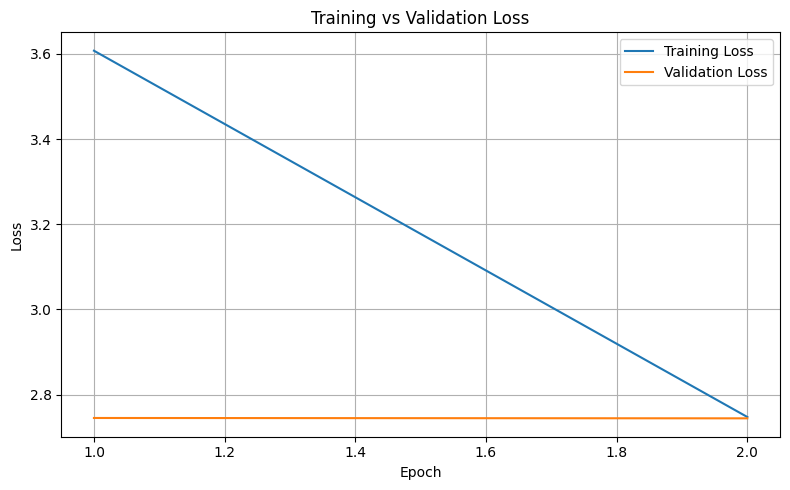

In [134]:
plot_losses(avg_train_loss, avg_val_loss)

In [135]:
word_map['hi']

206

In [137]:
for i, (src, tgt_in, tgt_out) in enumerate(test_loader):
  src, tgt_in, tgt_out = src.to(device), tgt_in.to(device), tgt_out.to(device)
  model.generate(tgt_in, max_len=25, start_token=word_map["<start>"])



RuntimeError: expected self and mask to be on the same device, but got mask on cpu and self on cuda:0